# Example Study

In this notebook, we outline some steps for an example study. The dataset is simulated to follow the advertising social robotics study (see Figure 11 of main paper).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causal_hri import data, estimators
from IPython.display import Image

In [2]:
np.random.seed(1234)

In [3]:
%load_ext tikzmagic

In [4]:
df = data.generate_robot_advertising_dataset(N=1000)

In [5]:
df.head()

ses  ad_type  recep  rev  qual
0    0        1      1    1     1
1    1        0      0    0     0
2    0        1      1    0     1
3    1        0      1    1     1
4    1        0      1    1     1

The variables are:

* "ses" (C): socioeconomic status of mall location
* "ad_type" (A): type of advertising used in a given mall (robotic versus standard)
* "recep" (M): receptivity of participants to advertising 
* "rev" (Y): revenue of mall
* "qual" (G): perceived quality of mall

We consider all the variables as binary for this example.

## Defining the Experimental Condition and Outcome

This depends on the scientific question being asked. If we are interested in understanding whether robotic advertising would be an effective tool for companies to use, we might consider asking if robotic advertising is more or less effective than standard advertising, ceteris paribus.

## List All Causally Relevant Variables

It is unlikely that all causally relevant variables will be observed. In addition to the variables listed, we might have other variables which are causally relevant but unmeasured. In the next step, after drawing the graph, we may consider if these omitted variables introduce bias.

For example, say that we do not observe the general economic conditions (Z) which can influence some of the variables.

## Draw a Graph

Given the causal variables, we can depict the relationships between the variables using a graph. If there is minimal knowledge about how these variables interact, then causal discovery methods (see notebook 05-causal-discovery) may be appropriate. For situations where we have sufficient domain knowledge, it may be possible to draw the graph directly. For example:

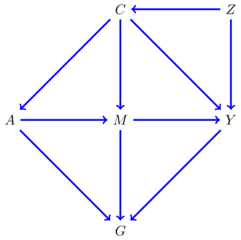

In [6]:
Image(filename='images/image1.png') 

Since we do not observe the economic conditions "econ" in the dataset, it is an unobserved confounder and thus can be represented by the following graph, where the red bidirected edge now encodes for the missing "econ" variable:

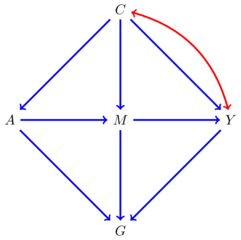

In [13]:
Image(filename='images/image2.png') 

## Identify a Causal Effect

Given the research question, a reasonable causal effect is $\mathbb{E}[Y(a=1)] - \mathbb{E}[Y(a=0)]$, representing the difference between the revenue $Y$ generated under robot advertising ($a=1$) versus under standard advertising ($a=0$).

Recall that the backdoor criterion, which is a sound criterion for identification of causal effects $\mathbb{E}[Y(a)]$, says that if a set $\mathbf{S}$ exists such that all backdoor paths between $A$ and $Y$ (all paths of the form $A \leftarrow \ldots \rightarrow Y$ with no colliders between $A$ and $Y$) are blocked, then 
$\mathbb{E}[Y(a)] = \sum_\mathbf{S} \mathbb{E}[Y | A=a, \mathbf{S}] p(\mathbf{S})$.

In this example, $\mathbf{S} = \{C\}$, since the only backdoor path is $A \leftarrow C \rightarrow Y$.

## Estimate a Causal Effect

The causal effect can be estimated using the techniques discussed in the notebook 02-adjusting-for-confounding.

In [8]:
n_bootstraps = 100
confounders = ["ses"]
g_results = []
ipw_results = []
for i in range(n_bootstraps):
    resampled_data = df.sample(frac=1, replace=True)
    ace_g = estimators.estimate_g_formula(data=resampled_data, outcome='rev', treatment='ad_type',
                  treatment_value=1, confounders=confounders) - estimators.estimate_g_formula(data=resampled_data, outcome='rev', treatment='ad_type',
                  treatment_value=0, confounders=confounders)
    g_results.append(ace_g)
    
    ace_ipw = estimators.estimate_ipw(data=resampled_data, outcome='rev', treatment='ad_type',
                  treatment_value=1, confounders=confounders) - estimators.estimate_ipw(data=resampled_data, outcome='rev', treatment='ad_type',
                  treatment_value=0, confounders=confounders)
    ipw_results.append(ace_ipw)

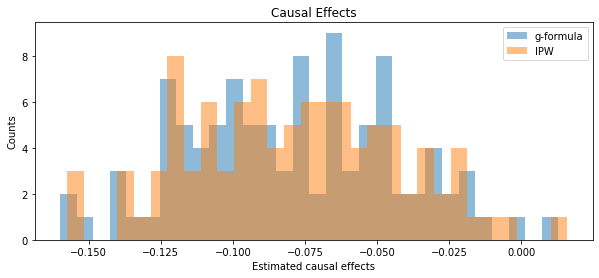

In [9]:
plt.figure(figsize=(10,4))
plt.hist(g_results, bins=30, label='g-formula', alpha=.5)
plt.hist(ipw_results, bins=30, label='IPW', alpha=.5)
plt.xlabel("Estimated causal effects")
plt.ylabel("Counts")
plt.title("Causal Effects")
plt.legend()

Note that results from both estimators are quite similar, which is a sanity check of sorts. If they were not, then this would be reason to suspect model misspecification of one or both of the models, and analysts might consider using a different model or changing the features that are estimated (e.g. adding interaction terms, terms of higher order, etc.). This is because the theory indicates that if both models are correct, then in the limit of infinite data, the results should coincide.

## Consider Sensitivity Analysis

Along the process of this case study we made certain assumptions and encoded these into the graph we drew. If there is reason to doubt the structure of this graph, then we might consider what these alternatives look like and repeat the analysis to see how the inference changes.

